## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## A. Read GL data:

In [4]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')
# Drop Nan entries in millan_v of Norway dataset
data_wgms = data_wgms.dropna(subset=data_wgms.columns.drop('DATA_MODIFICATION'))

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns


Number of glaciers: 31
Number of winter, summer and annual samples: 5959
Number of annual samples: 3022
Number of winter samples: 2937
Number of summer samples: 0


Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

## B. Progressive Transfer

In [5]:
data_NOR_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'NOR_dataset_monthly_full_with_millanv.csv')
data_monthly_CH_NOR = dataloader_gl.data

display(data_monthly_CH_NOR.head(2))

2025-07-09 07:13:55,314 - INFO - Loaded preprocessed data.
2025-07-09 07:13:55,316 - INFO - Number of monthly rows: 56965
2025-07-09 07:13:55,325 - INFO - Number of annual samples: 36350
2025-07-09 07:13:55,330 - INFO - Number of winter samples: 20615


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-3.957367,0.002545,-120958.0,132238.0,2673505.0,0.518889,-2003158.0,-0.577771,0.414947
1,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-7.107025,0.003408,107086.0,467112.0,414668.0,0.838310,-1135388.0,-1.247729,1.351297


In [6]:
# TRANSFER LEARNING SETUP
# Fine-tuning glaciers (4 Norway glaciers to adapt Swiss model)
fine_tuning_glaciers = ['Engabreen', 'Nigardsbreen', 'Aalfotbreen', 'Graasubreen']

# Test glaciers (all remaining Norway glaciers)
all_norway_glaciers = list(data_wgms['GLACIER'].unique())
test_glaciers = [g for g in all_norway_glaciers if g not in fine_tuning_glaciers]

print(f"Fine-tuning glaciers ({len(fine_tuning_glaciers)}): {fine_tuning_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in fine_tuning_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


Fine-tuning glaciers (4): ['Engabreen', 'Nigardsbreen', 'Aalfotbreen', 'Graasubreen']
Test glaciers (27): ['Rundvassbreen', 'Hansebreen', 'Austdalsbreen', 'Juvfonne', 'Hellstugubreen', 'Rembesdalskaaka', 'Svelgjabreen', 'Blomstoelskardsbreen', 'Moesevassbrea', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen', 'Vetlefjordbreen', 'Harbardsbreen', 'Storglombreen N', 'Graafjellsbrea', 'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre', 'Tunsbergdalsbreen', 'Vesledalsbreen', 'Austre Memurubreen', 'Vestre Memurubreen', 'Hoegtuvbreen', 'Bondhusbrea']
Train glaciers: (4) ['Engabreen' 'Aalfotbreen' 'Nigardsbreen' 'Graasubreen']
Test glaciers: (27) ['Rundvassbreen' 'Hansebreen' 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen'
 'Rembesdalskaaka' 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Svartisheibreen' 'Trollbergdalsbreen'
 'Vetlefjordbreen' 'Harbardsbreen' 'Storglombreen N' 'Graafjellsbrea'
 'Breidablikkbrea' 'Blaaisen' 'Blabree

In [8]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train data glacier distribution: GLACIER
Nigardsbreen    11343
Aalfotbreen      7061
Engabreen        2813
Graasubreen       181
Name: count, dtype: int64
Val data glacier distribution: GLACIER
Nigardsbreen    2890
Aalfotbreen     1701
Engabreen        738
Graasubreen       49
Name: count, dtype: int64
Train data shape: (21398, 29)
Val data shape: (5378, 29)


## Neural Network:

In [9]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate)

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (21398, 28)
Shape of validation dataset: (5378, 28)
Shape of testing dataset: (30189, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


### Initialise network:

In [10]:
# Early stopping with more patience for fine-tuning
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,  # More patience for fine-tuning
    threshold=1e-5,
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                                monitor='valid_loss',
                                mode='min',
                                factor=0.5,
                                patience=8,
                                threshold=0.005,
                                threshold_mode='rel',
                                verbose=True)

dataset = dataset_val = None  # Initialized hereafter
def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

# Fine-tuning parameters (lower learning rate, fewer epochs)
custom_params = {
    'lr': 0.0001,  # Much lower learning rate for fine-tuning
    'batch_size': 64,  # Smaller batch size
    'module__layer0': 64,
    'module__layer1': 64,
    'module__layer2': 32,
    'module__layer3': 32,
    'module__dropout': 0.2,
    'optimizer': torch.optim.Adam
}

params = custom_params

args = {
    'module': BiggerNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__layer0': params['module__layer0'],
    'module__layer1': params['module__layer1'],
    'module__layer2': params['module__layer2'],
    'module__layer3': params['module__layer3'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 300,  # Change from 300 to 50 for fine-tuning
    'optimizer': params['optimizer'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Create datasets:

In [11]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (2279,) (2279,)
validation: (570,) (570,)


### Train custom model:

In [13]:
TRAIN = False
if TRAIN:
    # STEP 1: Load the pre-trained Swiss model
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-07_CH_with_millanv.pt"
    
    # Load with original Swiss parameters (higher LR, more epochs)
    swiss_args = {
        'module': BiggerNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__layer0': 64,
        'module__layer1': 64,
        'module__layer2': 32,
        'module__layer3': 32,
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,  # Original Swiss learning rate
        'max_epochs': 300,
        'optimizer': torch.optim.Adam,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
        ]
    }
    
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg,
        model_filename,
        **{**swiss_args, **param_init}
    )
    
    print("✓ Swiss model loaded successfully!")
    
    # STEP 2: Update model parameters for fine-tuning
    print("Updating model for fine-tuning...")
    loaded_model = loaded_model.set_params(
        lr=args['lr'],  # Lower learning rate
        max_epochs=args['max_epochs'],  # Fewer epochs
        batch_size=args['batch_size'],  # Smaller batch size
        callbacks=args['callbacks']  # Fine-tuning callbacks
    )
    
    print("✓ Model parameters updated for fine-tuning!")
    print(f"Fine-tuning LR: {args['lr']}")
    print(f"Fine-tuning epochs: {args['max_epochs']}")
    print(f"Fine-tuning batch size: {args['batch_size']}")
    
    # STEP 3: Fine-tune on Norway glaciers
    print("Starting fine-tuning on 4 Norway glaciers...")
    print('Fine-tuning parameters:')
    for key, value in args.items():
        if key not in ['callbacks']:
            print(f"{key}: {value}")
    
    loaded_model.fit(dataset.X, dataset.y)
    
    # STEP 4: Save the fine-tuned model
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_epochs_{args['max_epochs']}_{current_date}"
    
    plot_training_history(loaded_model, skip_first_n=2)
    
    # Save the fine-tuned model
    loaded_model.save_model(finetuned_model_filename)
    
    # Save fine-tuning params
    finetuned_params_filename = f"nn_params_finetuned_epochs_{args['max_epochs']}_{current_date}.pkl"
    with open(f"models/{finetuned_params_filename}", "wb") as f:
        pickle.dump(args, f)
    
    print(f"✓ Fine-tuned model saved as: {finetuned_model_filename}")
    
else:
    # Load the fine-tuned model (if you've already trained it)
    finetuned_model_filename = "nn_model_finetuned_epochs_300_2025-07-08_CH_with_millanv.pt"  # Update with actual date
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg,
        finetuned_model_filename,
        **{**args, **param_init}
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')
    print(f"✓ Loaded fine-tuned model: {finetuned_model_filename}")

✓ Loaded fine-tuned model: nn_model_finetuned_epochs_300_2025-07-08_CH_with_millanv.pt


### Load model and make predictions:

In [14]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

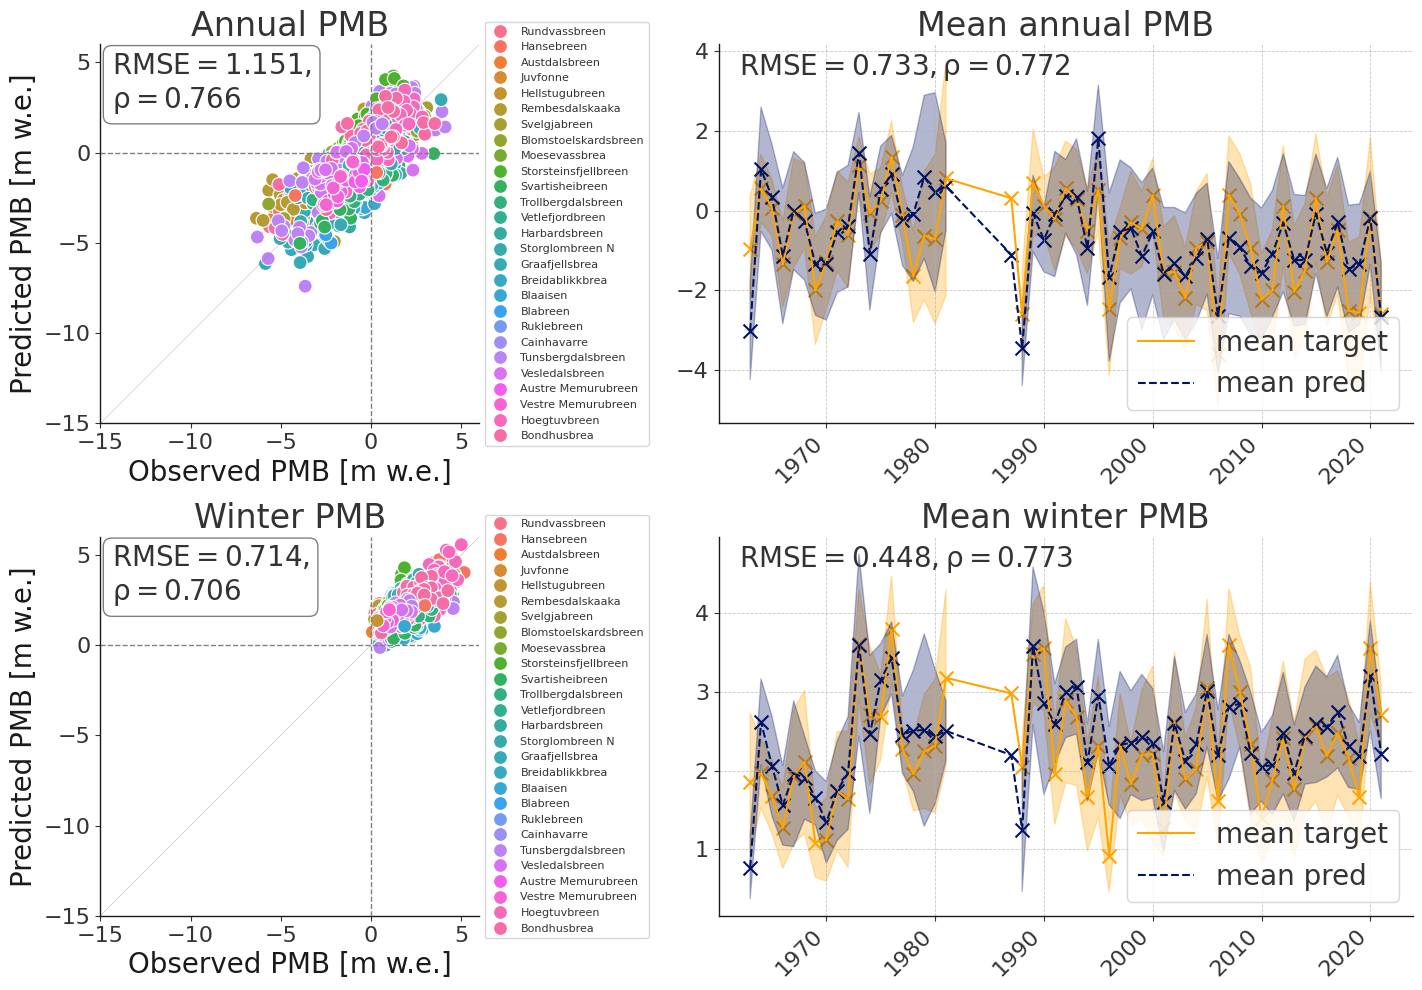

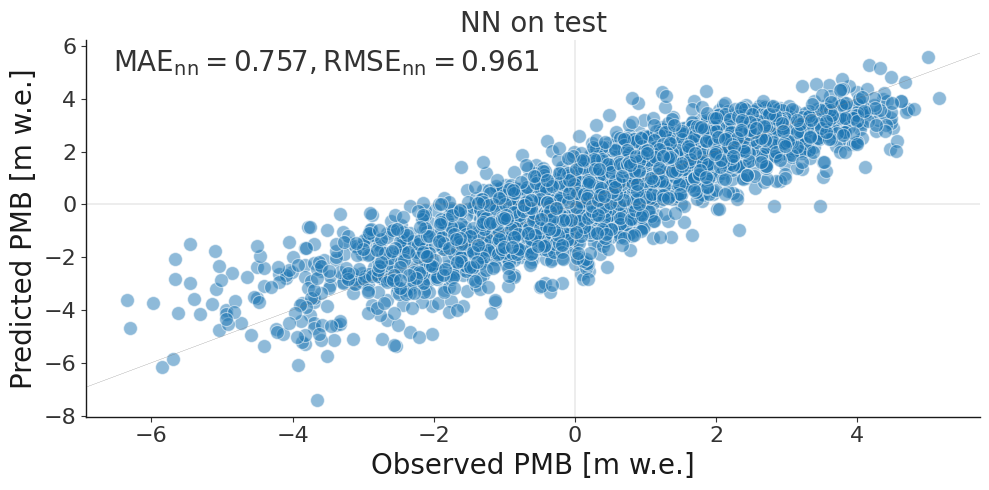

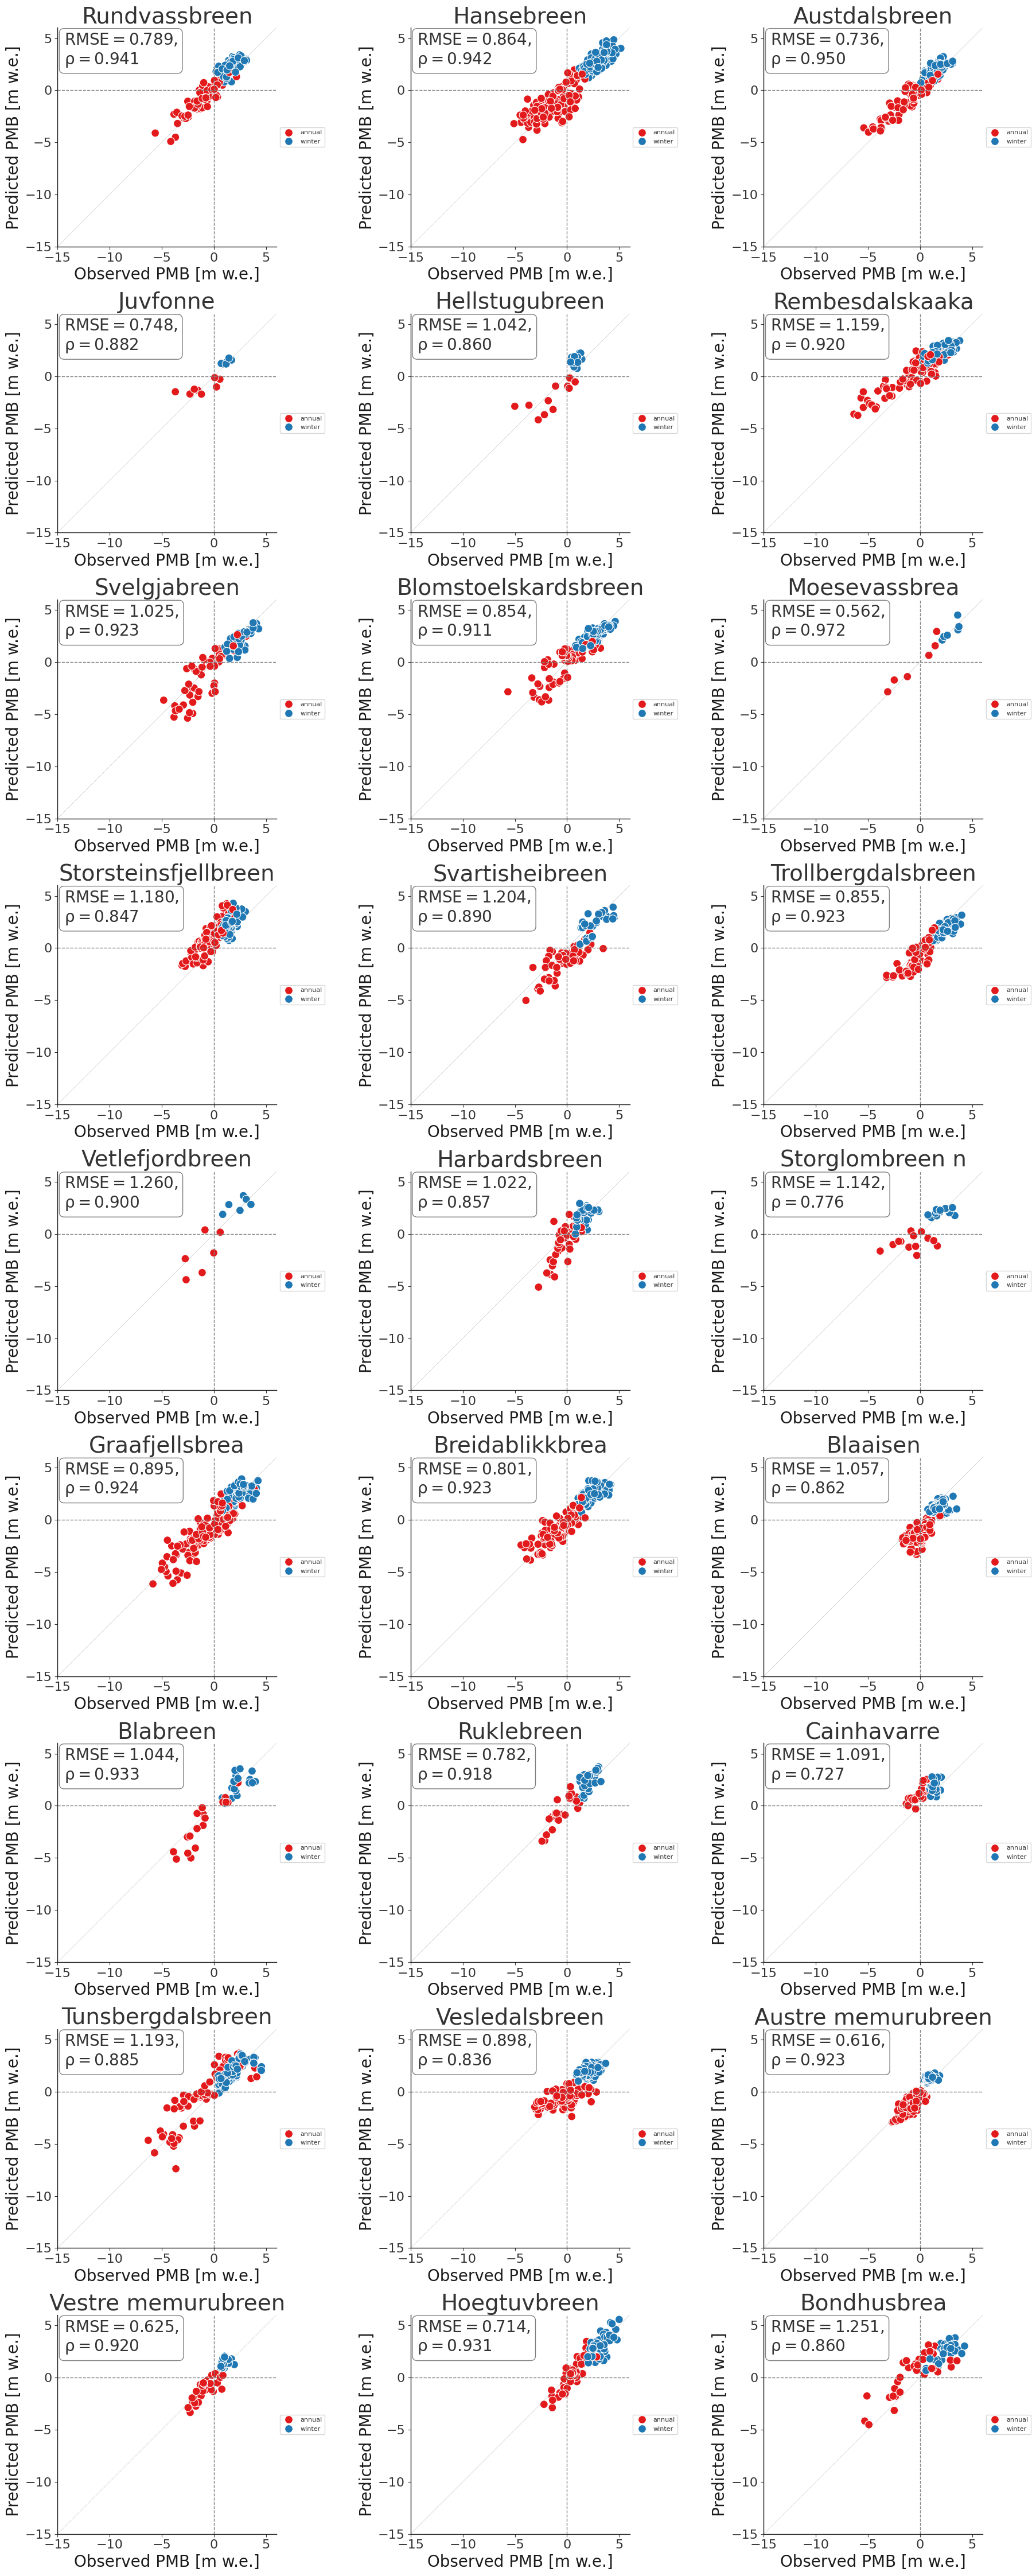

In [15]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))